#### Limitations
So far, all solvers use uniform cell sizes and work only in 1D (however, `LinearSolver` seems to be almost ready for 2D simulations). Material properties are also assumed constant in the domain.

In [1]:
using PyPlot
using LinearAlgebra
using Statistics
include("boundary_conditions.jl");

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XaELc/src/init.jl:198


#### Define a gradient operator
That can differentiate an electric potential field to obtain an electric field.
In order to improve performance, ∇ can be called with a preallocated result and
can flip sign in the result.

In [2]:
using StaticArrays
include("gradient.jl")

#### In-place Periodic Solver
Is aimed at solving a periodic Poisson equation without explicitely assembling the
system of linear equations. As it is a singular problem, which is non-determined
up to a constant value, the result has to be solved iteratively and some additional
constraints have to be imposed. In this case we assume that the mean value of the
solution is 0. We achieve this by substracting the original solution's mean value.

In [3]:
include("iterative_methods.jl")
include("inplace_periodic_solver.jl")

solution(ps::InPlacePeriodicSolver) = ps.u
gradient(ps::InPlacePeriodicSolver) = let periodic = PeriodicBC()
    GradientOperator(ps.nx, ps.δx, (periodic, periodic))
end

gradient (generic function with 1 method)

#### Linear Solver
The former solver was limited by the fact that it worked only for periodic boundary conditions. The linear solver is aimed at solving a general Poisson equations with both periodic and Dirichlet boundary conditions. It forms a system of linear equations.

In [4]:
using SparseArrays
include("linear_solver.jl")
include("linear_solver1.jl")
include("linear_solver2.jl")

solution(ps::LinearSolver) = reshape(ps.u, ps.n...)
gradient(ps::LinearSolver) = GradientOperator(ps.n[1], ps.δ[:], ps.bcs)

gradient (generic function with 2 methods)

#### Some additional solvers
(work-in-progress)

In [5]:
struct MutligridSolver end
struct FastFourierTransformSolver end

#### General problem parameters
The Poisson equation is solved on a domain with $x \in <0, 1>$ using a Finite Volume Method approach.
The source term is defined as $f(x) = (72\pi)^2 \sin(4\pi x) \sin(2\pi x)$.

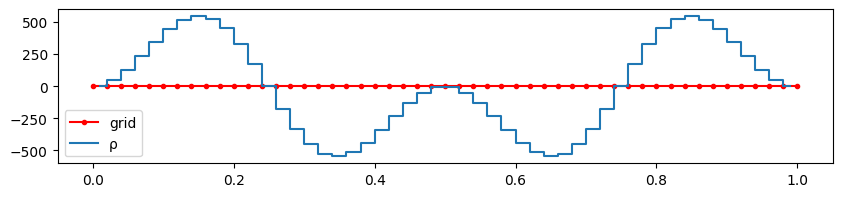

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/bach/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [6]:
h  = 0.02
xf = 0.0:h:1.0
xc = 0.5 .* xf[1:end-1] .+
     0.5 .* xf[2:end]
φref = @.        cos(2π * 3xc)-9cos(2π * xc)
f(x) = 72.0π^2 * sin(2π * 2x) * sin(2π * x)
ρ = f.(xc)
ρ.-= mean(ρ) # substract mean value as it is a crucial condition

figure(figsize=(10, 2))
plot(xf, zero(xf), "r.-")
step(xc, ρ, where="mid")
legend(["grid", "ρ"]);

The above problem is solved using a Linear Solver. We can apply both periodic and Dirichlet boundary conditions.
In the case of boundary conditions on both boundaries we can impose additional constraint on a mean solution value. This is the reason why we substract the mean solution value after calculating the electric potential.

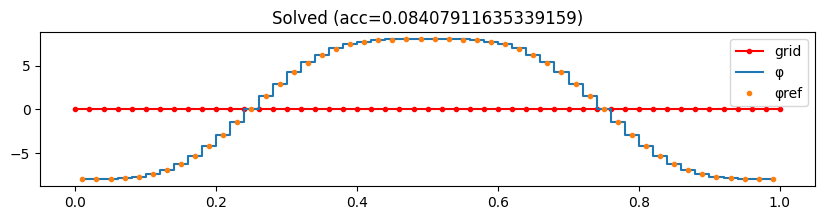

  1.820268 seconds (4.45 M allocations: 232.892 MiB, 6.67% gc time, 99.97% compilation time)


In [7]:
bc = PeriodicBC()
ps = LinearSolver(xf, left=bc, right=bc)
@time it = solve!(ps, ρ)
φ  = solution(ps)
φ.-= mean(φ) # substract mean value when both boundary conditions are periodic

figure(figsize=(10, 2))
title("Solved (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ", "φref"]);

Once again the same Poisson equation is being solved with periodic boundary conditions on both boundaries. In this case the `solve!` procedure substract the mean value in the end.

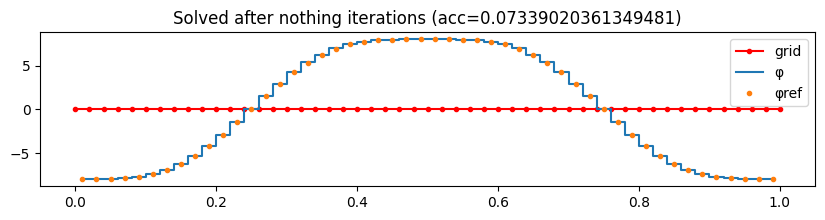

  0.265156 seconds (653.18 k allocations: 34.170 MiB, 16.53% gc time, 99.91% compilation time)


In [8]:
ps = InPlacePeriodicSolver(xf; maxiter=1000)
@time it = solve!(ps, ρ)
φ  = solution(ps)
φ.-= mean(φ) # substract mean value when both boundary conditions are periodic

figure(figsize=(10, 2))
title("Solved after $it iterations (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ", "φref"]);

Now we can also differentiate the electric potential and obtain the electric field which uses the information about boundaries.

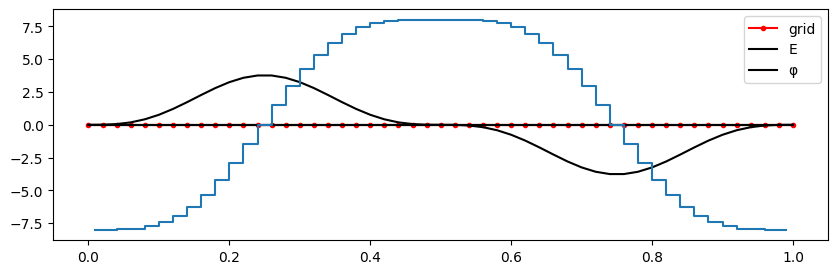

  135.466 ns (1 allocation: 16 bytes)


In [9]:
using BenchmarkTools
E = zeros(SVector{3, Float64}, length(xf));
∇ = gradient(ps)
@btime ∇($φ; result=$E)

figure(figsize=(10, 3))
plot(xf, zero(xf), "r.-")
plot(xf, 0.05E, "k-")
step(xc, φ, where="mid")
legend(["grid", "E", "φ"]);

#### Compare convergence of different methods
Comparison between iterative solvers both from Julia's IterativeSolvers.jl and our own.

In [10]:
import IterativeSolvers

ps = LinearSolver(xf, left=bc, right=bc)
nothing

It seems that GMRES has a good convergence on the given problem

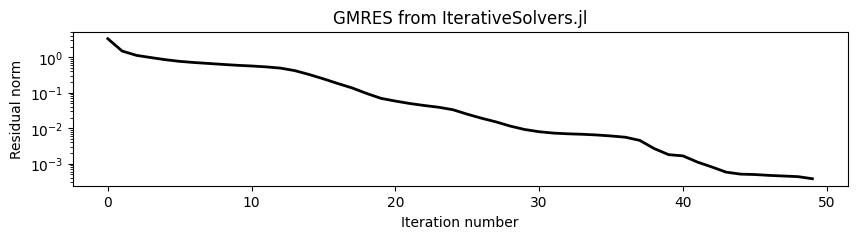

  0.010584 seconds (9.02 k allocations: 514.901 KiB, 98.44% compilation time)


In [11]:
x = randn(length(ps.u))
rhs = ps.b .- ρ .* h .^ 2
x, ch = IterativeSolvers.gmres!(x, ps.A, rhs, log=true)
resnorm = ch.data[:resnorm]

x = randn(length(ps.u))
@time IterativeSolvers.gmres!(x, ps.A, rhs)

figure(figsize=(10, 2))
title("GMRES from IterativeSolvers.jl")
xlabel("Iteration number")
ylabel("Residual norm")
semilogy(resnorm, linewidth=2, linestyle="-", color="k");

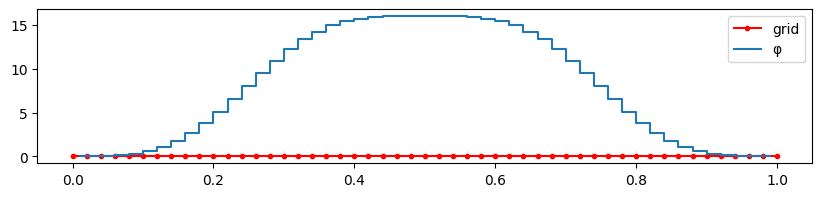

  0.032353 seconds (19.51 k allocations: 1.079 MiB, 85.71% compilation time)


In [12]:
ps = LinearSolver(xf, left=DirichletBC(), right=DirichletBC())
@time it = solve!(ps, ρ)
φ  = solution(ps)

figure(figsize=(10, 2))
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
legend(["grid", "φ", "φref"]);

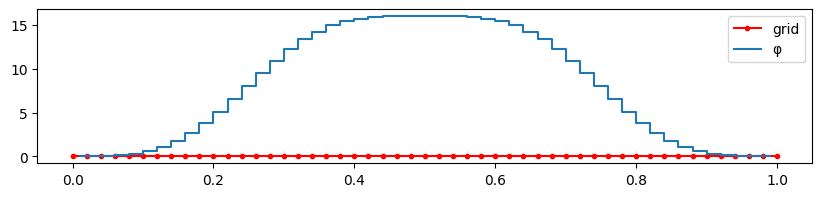

  0.000114 seconds (67 allocations: 69.891 KiB)


In [13]:
ps = LinearSolver(xf, left=DirichletBC(), right=DirichletBC())
@time it = solve!(ps, ρ)
φ  = solution(ps)

figure(figsize=(10, 2))
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
legend(["grid", "φ", "φref"]);

### Two-dimensional Poisson Solver
We will start with a simple example from W. Briggs, V. Henson, and S. McCormick, _Implementation_ in _A multigrid tutorial_, SIAM, 2000, ch. 4, pp. 64-68.

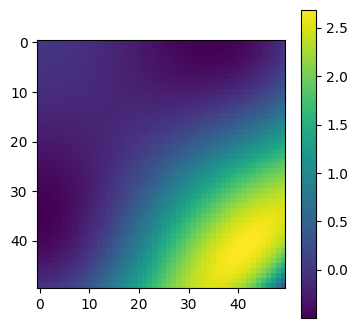

PyObject <matplotlib.colorbar.Colorbar object at 0x121ba9880>

In [14]:
h  = 0.02
xf = 0.0:h:1.0
yf = 0.0:h:1.0
xc = 0.5 .* xf[1:end-1] .+
     0.5 .* xf[2:end]
yc = 0.5 .* yf[1:end-1] .+
     0.5 .* yf[2:end]
nx = length(xc)
ny = length(yc)
xx = repeat(xc,   1, ny)
yy = repeat(yc', nx,  1)
f(x, y) = -2((1 - 6x^2) * y^2 * (1 - y^2) +
             (1 - 6y^2) * x^2 * (1 - x^2))
ρ = f.(xx, yy)
φref = @. (xx^2 - xx^4) * (yy^4 - yy^2)

figure(figsize=(4, 4))
imshow(ρ')
colorbar()

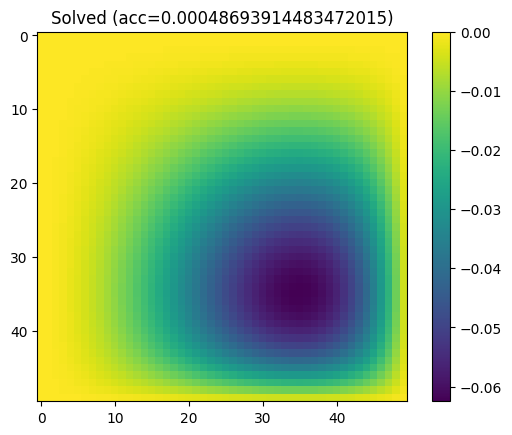

  0.047027 seconds (34.55 k allocations: 5.425 MiB, 84.61% compilation time)


In [15]:
bc = DirichletBC()
ps = LinearSolver(xf, yf, left=bc, right=bc, upper=bc, lower=bc)
@time it = solve!(ps, reshape(ρ,:))
φ  = solution(ps)
title("Solved (acc=$(norm(φ - φref)))")
imshow(φ')
colorbar();

### Let's build an electron gun!
After that, we will check if we can prescribe an electric potential inside the computational domain.

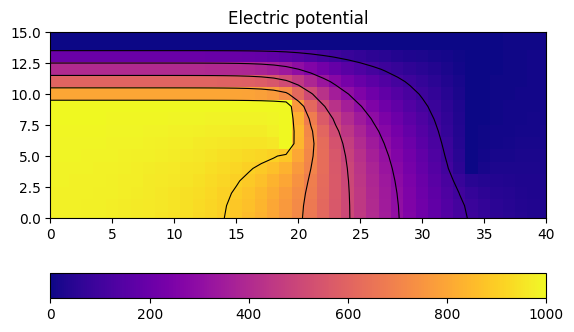

  0.038608 seconds (19.52 k allocations: 6.397 MiB, 72.59% compilation time)


In [16]:
h  = 0.01
xf = 0.0:h:2.0
yf = 0.0:h:0.2
xc = 0.5 .* xf[1:end-1] .+
     0.5 .* xf[2:end]
yc = 0.5 .* yf[1:end-1] .+
     0.5 .* yf[2:end]
nx = length(xc)
ny = length(yc)
xx = repeat(xc,   1, ny)
yy = repeat(yc', nx,  1)

ρ = zeros(nx, ny)
gnd = DirichletBC(0.)
dbc  = DirichletBC(1000.)
bc = NeumannBC()
ps = LinearSolver(xf, yf, left=bc, right=bc, upper=bc, lower=bc)
@inbounds for i=1:19, j=10 fixed!(ps, dbc.value, i, j) end
@inbounds for i=1:34, j=15 fixed!(ps, gnd.value, i, j) end
@inbounds for i=20, j=7:10 fixed!(ps, dbc.value, i, j) end
@inbounds for i=35, j=5:15 fixed!(ps, gnd.value, i, j) end

@time it = solve!(ps, reshape(ρ,:))
φ  = solution(ps)
imshow(φ', cmap="plasma"); colorbar(orientation="horizontal")
contour(φ', (100, 300, 500, 700, 900), colors="black", linewidths=0.8)
xlim((0, 40))
ylim((0, 15))
title("Electric potential")
nothing

In [17]:
include("gradient.jl")
E = zeros(SVector{3, Float64}, length(xf), length(yf));
∇ = GradientOperator2(ps.n[1], ps.n[2], ps.δ[1], ps.δ[2], ps.bcs)
∇(φ; result=E);

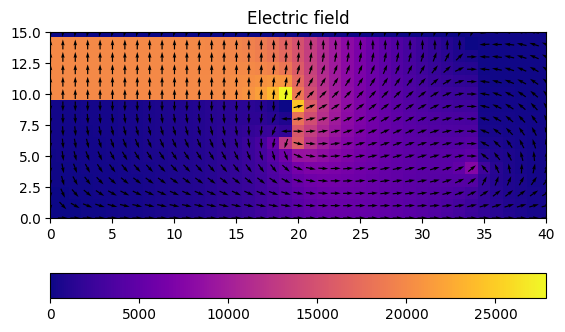

In [18]:
Ex = [-e[1] / norm(e) for e in E]
Ey = [-e[2] / norm(e) for e in E]
Em = [sqrt(e[1]^2 + e[2]^2) for e in E]
imshow((Em'), cmap="plasma"); colorbar(orientation="horizontal")
quiver(Ex', Ey', color="black", pivot="middle", scale=50)
xlim((0, 40))
ylim((0, 15))
title("Electric field")
nothing

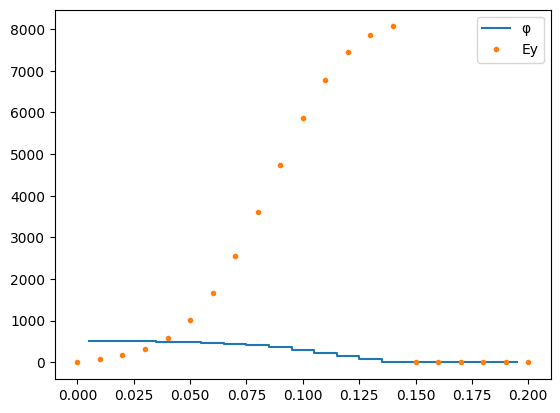

PyObject <matplotlib.legend.Legend object at 0x121b5c640>

In [19]:
step(yc, φ[25, :])
plot(yf, [-e[2] for e in E[25,:]], ".")
legend(("φ", "Ey"))

### Coaxial?

In [20]:
include("linear_solver2.jl")
h  = 0.01
rf = 0.1:h:1.0
zf = 0.0:h:1.0
rc = 0.5 .* rf[1:end-1] .+
     0.5 .* rf[2:end]
zc = 0.5 .* zf[1:end-1] .+
     0.5 .* zf[2:end]
nr = length(rc)
nz = length(zc)
rr = repeat(rc,   1, nz)
zz = repeat(zc', nr,  1)
nothing

In [21]:
ρ = zeros(nr, nz)
gnd = DirichletBC(0.)
dbc = DirichletBC(1000.)
bc = NeumannBC()
ps = LinearSolver(Val(:zr), zf, rf, left=bc, right=bc, upper=dbc, lower=gnd)
nothing

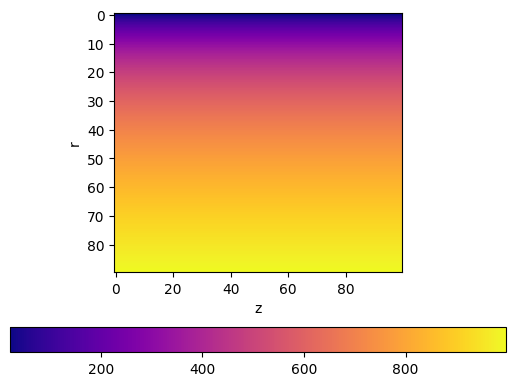

  0.071889 seconds (19.52 k allocations: 14.248 MiB, 16.60% gc time, 39.57% compilation time)


PyObject Text(81.36388888888892, 0.5, 'r')

In [22]:
@time it = solve!(ps, reshape(ρ,:))
φ = solution(ps)
imshow(φ', cmap="plasma")
colorbar(orientation="horizontal")
xlabel("z")
ylabel("r")

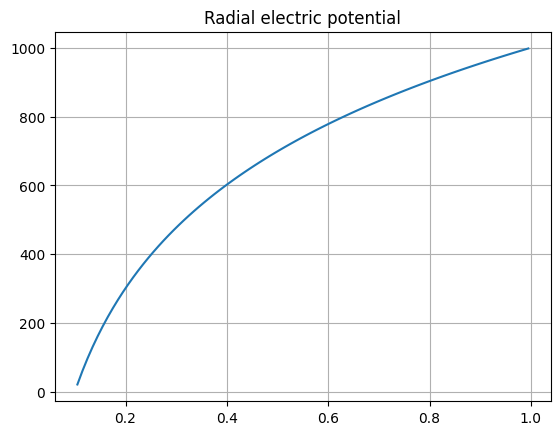

(21.223968880269748, 997.8227608151254)

In [23]:
plot(rc, φ[1,:])
grid()
title("Radial electric potential")
extrema(φ)

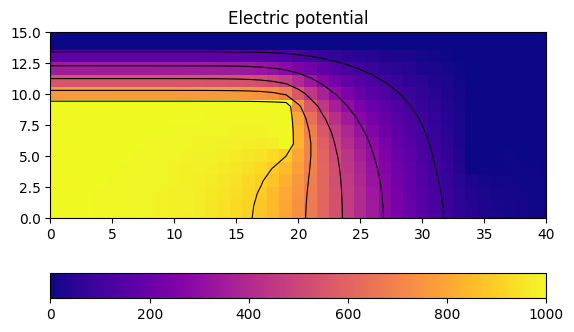

  0.011249 seconds (76 allocations: 5.387 MiB)


In [24]:
h  = 0.01
zf = 0.0:h:2.0
rf = 0.0:h:0.2
zc = 0.5 .* zf[1:end-1] .+
     0.5 .* zf[2:end]
rc = 0.5 .* rf[1:end-1] .+
     0.5 .* rf[2:end]
nz = length(zc)
nr = length(rc)
zz = repeat(zc,   1, nr)
rr = repeat(rc', nz,  1)

ρ = zeros(nz, nr)
gnd = DirichletBC(0.)
dbc  = DirichletBC(1000.)
bc = NeumannBC()
ps = LinearSolver(Val(:zr), zf, rf, left=bc, right=bc, upper=bc, lower=bc)
@inbounds for i=1:19, j=10 fixed!(ps, dbc.value, i, j) end
@inbounds for i=1:34, j=15 fixed!(ps, gnd.value, i, j) end
@inbounds for i=20, j=7:10 fixed!(ps, dbc.value, i, j) end
@inbounds for i=35, j=5:15 fixed!(ps, gnd.value, i, j) end

@time it = solve!(ps, reshape(ρ,:))
φ  = solution(ps)
imshow(φ', cmap="plasma"); colorbar(orientation="horizontal")
contour(φ', (100, 300, 500, 700, 900), colors="black", linewidths=0.8)
xlim((0, 40))
ylim((0, 15))
title("Electric potential")
nothing

In [25]:
E = zeros(SVector{3, Float64}, length(xf), length(yf));
∇ = GradientOperator2(ps.n[1], ps.n[2], ps.δ[1], ps.δ[2], ps.bcs)
∇(φ; result=E);

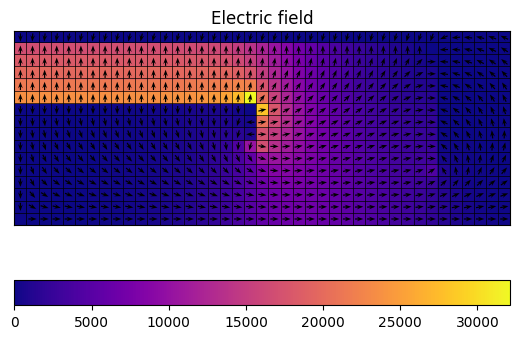

In [26]:
Ex = [-e[1] / norm(e) for e in E]
Ey = [-e[2] / norm(e) for e in E]
Em = [sqrt(e[1]^2 + e[2]^2) for e in E]

#figure(dpi=150)
imshow((Em'), cmap="plasma"); colorbar(orientation="horizontal")
quiver(Ex', Ey', color="black", pivot="middle", scale=60, headwidth=4, headlength=5.5, headaxislength=4)

ax = gca()
ax.tick_params(axis="both", length=0.)
ax.set_xticks((0:nz) .- 0.5)
ax.set_yticks((0:1.01:nr) .- 0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which="major", color="k", linestyle="-", linewidth=0.5)
ax.set_aspect("equal")
xlim((-0.5, 40.5))
ylim((-0.5, 15.5))
title("Electric field")
nothing

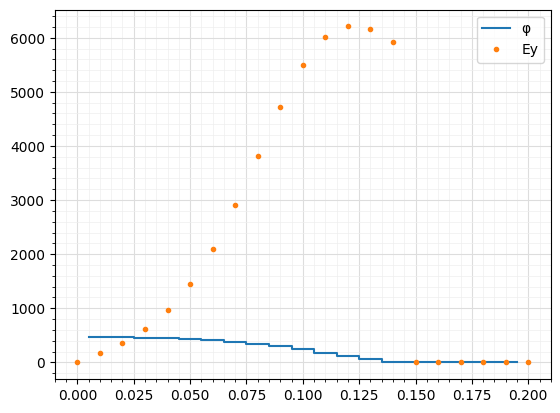

In [27]:
#figure(dpi=150)
step(yc, φ[25, :])
plot(yf, [-e[2] for e in E[25,:]], ".")
legend(("φ", "Ey"))
ax = gca()
ax.grid(which="major", color="#DDDDDD", linewidth=0.8)
ax.grid(which="minor", color="#EEEEEE", linestyle="-", linewidth=0.5)
ax.minorticks_on()

In [28]:
h  = 2π/360
θf = 0π:h:2π
rf = 0.38:0.01:1.02
rf = 4.11collect(rf)

θc = 0.5 .* θf[1:end-1] .+
     0.5 .* θf[2:end]
rc = 0.5 .* rf[1:end-1] .+
     0.5 .* rf[2:end]
nθ = length(θc)
nr = length(rc)
θθ = repeat(θc,   1, nr)
rr = repeat(rc', nθ,  1)

ρ = zeros(nθ, nr)
#ρ[:, 1:8] .= 3e4randn(nθ, 8)
gnd = DirichletBC(0.)
dbc  = DirichletBC(1000.)
bc = NeumannBC()
@time ps = LinearSolver(Val(:θr), θf, rf, upper=bc, lower=dbc)

for i=1:nθ, j=62:64    fixed!(ps, gnd.value, i, j) end
for i=21:60,   j=14:62 fixed!(ps, gnd.value, i, j) end
for i=81:120,  j=14:62 fixed!(ps, gnd.value, i, j) end
for i=141:180, j=14:62 fixed!(ps, gnd.value, i, j) end
for i=201:240, j=14:62 fixed!(ps, gnd.value, i, j) end
for i=261:300, j=14:62 fixed!(ps, gnd.value, i, j) end
for i=321:360, j=14:62 fixed!(ps, gnd.value, i, j) end

@time it = solve!(ps, reshape(ρ,:))
φ  = solution(ps)
nothing

  1.806657 seconds (765.42 k allocations: 45.073 MiB, 1.19% gc time, 39.10% compilation time)
  0.140512 seconds (19.52 k allocations: 34.915 MiB, 11.95% gc time, 20.25% compilation time)


In [29]:
nθ, nr

(360, 64)

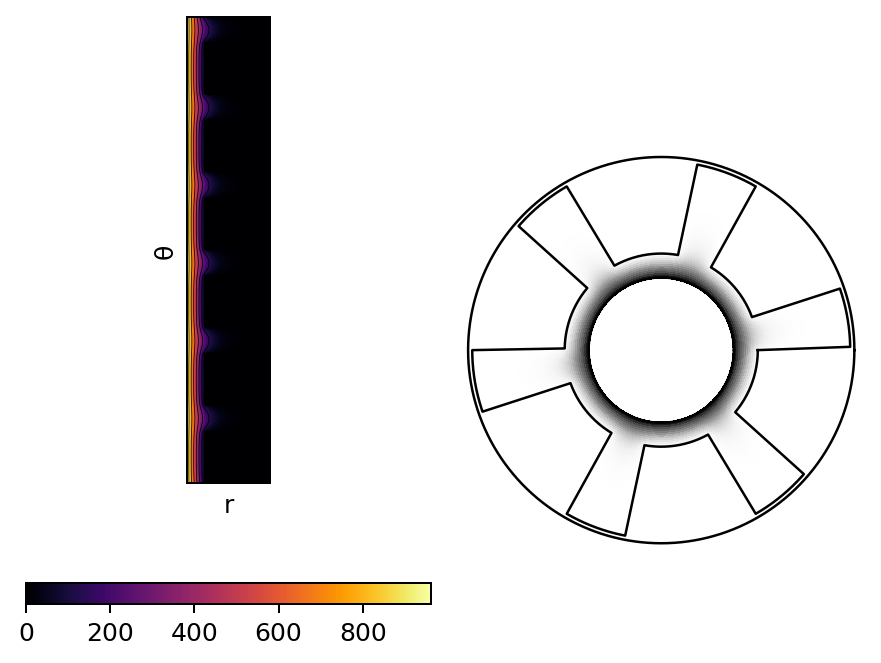

In [30]:
using PyPlot

function quadmesh(rf, tf, V; cmap=get_cmap("viridis"))
    nr = length(rf)
    nt = length(tf)
    N = PyPlot.matplotlib.colors.Normalize(vmin=minimum(V), vmax=maximum(V))
    C = cmap(N(V[:]))
    R = repeat(rf, 1, nt)
    T = repeat(tf',nr, 1)
    coords = zeros(nr, nt, 2)
    coords[:,:,1] .= T
    coords[:,:,2] .= R

    mesh = PyPlot.matplotlib.collections.QuadMesh(nt-1, nr-1, coords, facecolors=C,
                                                  rasterized=true,
                                                  antialiased=false,
                                                  linewidth=0)
    return mesh
end

fig = figure(figsize=(5,4), dpi=180)
ax = fig.add_subplot(1,2,2, polar=true, frameon=false)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_rorigin(-0.5)
#ax.set_rmin(0.)
#ax.set_rmax(1.)
ax.grid(false)
ax.add_collection(quadmesh(rf, θf, φ; cmap=get_cmap("Greys")))
let outline = 2.1ones(length(θf))
    for i = 0:nθ
        if  21 > i >= 2   outline[i] = 4.11 end
        if  81 > i >= 61  outline[i] = 4.11 end
        if 141 > i >= 121 outline[i] = 4.11 end
        if 201 > i >= 181 outline[i] = 4.11 end
        if 261 > i >= 241 outline[i] = 4.11 end
        if 321 > i >= 301 outline[i] = 4.11 end
    end
    ax.plot(θf, 1.00ones(nθ+1), "white", linewidth=0)
    ax.plot(θf, 0.01ones(nθ+1), "white", linewidth=0)
    ax.plot(θf, 1.58ones(nθ+1), "black", linewidth=1)
    ax.plot(θf, 4.20ones(nθ+1), "black", linewidth=1)
    ax.plot(θf, outline, "black", linewidth=1)
    #ax.plot(θf, .2sin.(2.5θf .- 0.5).^4 .+ 1.65, "violet", linewidth=0.9)
end
ax = fig.add_subplot(1,2,1, frameon=true)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")
ax.grid(false)
imshow(φ, cmap=get_cmap("inferno"))
colorbar(orientation="horizontal")
contour(φ, colors="black", linewidths=0.3)
xlabel("r"); ylabel("θ");

tight_layout()

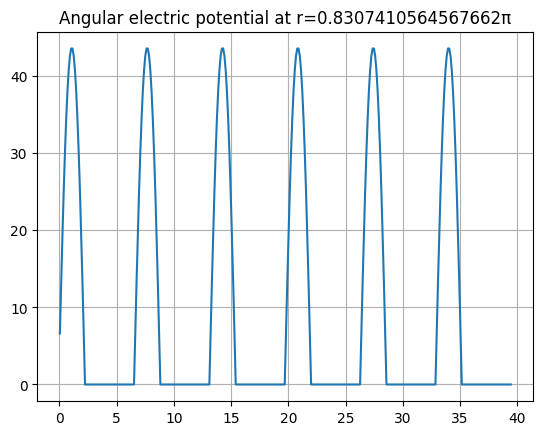

In [31]:
plot(2π.*θc, φ[:,26], "-"); grid()
title("Angular electric potential at r=$(rc[26]/π)π");